# Methodology 

In this section, I will provide an example illustration of PCA implementation, stepping through the algorithm of eigendecomposition calculation for PCA. Understanding this process is crucial for grasping how PCA reduces dimensionality and extracts the essential features of a dataset. By the end of this demonstration, I'll compile each step into a model named myPCA, implementing the illustrated algorithm.


- ## Example Problem Setup
In this demonstration, we apply a relatively straightforward five-dimensional dataset. A set of noisy data is generated using `sklearn.datasets.make_biclusters`, which creates a set of clustered data. The presence of clustered data allows us to visualize how well PCA performs in terms of preserving information in the dataset. 

In [1]:
from sklearn import datasets
import numpy as np
n_samples = 100
n_features = 5
X, rows, cols= datasets.make_biclusters(shape = (n_samples, n_features), n_clusters= 3, noise= 20, 
                                        random_state=42)
labels = np.argmax(rows, axis = 0) # all labels
print(X.shape)

(100, 5)


- Visualization of the example dataset (visulization code refers to Appendix)
![Fig 1. An Example of High-dimensional Data](./figs/example_of%20_comlex_data.png)

In [2]:
# import dataset from sklearn 
from sklearn import datasets
n_samples = 100
n_features = 5
X, rows, cols= datasets.make_biclusters(shape = (n_samples, n_features), n_clusters= 3, noise= 20, 
                                        random_state=42)
print(X.shape)

(100, 5)


- ## Data Scaling

Before performing PCA, we will have to scale the dataset to centered at 0 and scaled. Since the covariance matrix is calculated by $\frac {(X-m)'(X-m)}{n}$, by mean shifting the data, we can then calcualte the covariance matrix by $\frac {(X_{shifted})'(X_{shifted})}{n}$. Standardizing further ensures uniform units across all features, promoting consistency in scale.

In [3]:
# Standardization 
import numpy as np
def standardize(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

X_std = standardize(X)

- ## PCA Model


### 1. Construct the covariance matrix 


Recall Covariance martrix:

$Cov(X, Y) = \frac{\sum_{i = 1}^{N} (x_i-\mu_x)(y_i - \mu_y)}{N-1}$ --- (1)
    

    
$\mathbf{COV} = \left[\begin{array}{ccccc}
 Cov(X_1, X_1) & Cov(X_1, X_2) & ... & Cov(X_1, X_n) \\
 Cov(X_2, X_1) & Cov(X_2, X_2) & ...& Cov(X_2, X_n)\\
 \vdots\ &&&\vdots\\\
 Cov(X_n, X_1) & ... & ...       &Cov(X_n, X_n)
 \end{array}\right]_{(n, n)}$ --- (2)
 


To compute the covariance matrix of data $X$ is simple. 

Assumed each column of data $X$ is stadardized (Centralized and unit variance), the covariance can simply be computed as the correlation of two features:
 
$corr(X_1, X_2) = \frac{cov(X_1,X_2)}{\sigma_{X_1}\sigma_{X_2}}$ where ${\sigma_{X_1}, \sigma_{X_2}} = 1$  --- (3)

Therefore 

$corr(X_1, X_2) = cov(X_1,X_2)$ --- (4)

The covariance matrix can be simply calculated as 
$\mathbf{COV} = \frac{X^T X}{n-1}$ --- (5)

With this condistion stands, we can define the covariance matrix of data $X$ as:

In [4]:
# Covariance Matrix
def covMat(X):
    # or return (X.T @ X)/X.shape[0] (X is centered)
    S = np.cov(X, rowvar=False) # rows are records space; columns are the feature space
    return S
# Standardized data X
COV = covMat(X_std)

### 2. Find the eigenvectors and eigenvalues of the covariance matrix

Recall:

1. $\mathbf{COV}$ is a symmetric matrix, therefore, the eigenvectors are orthogonal to each other and the eigenvalues are guaranteed to be positive. 

2. Eigen decomposition package from `numpy.linalg.eig` introduced in [Lecture 17](https://kitchingroup.cheme.cmu.edu/f23-06623/lectures/17-linear-algebra-2/17-linear-algebra-2.html) 


The eigenvalue problem of data $X$ can be described as following:

$\mathbf{COV}_{(n,n)} \mathbf{P}_{(n,n)} = \lambda \mathbf{P}_{(n,n)}$ --- (6)

Again, in Python, we can solve this problem using `numpy.linalg.eig` which takes in matrix we intend to perform operation on (i.e. the covariance matrix $\mathbf{COV}$) and returns values $w$, $v$, which are eigenvectors and eigenvalues repectively. 


In [5]:
# Calculating eigenvalues and eigenvectors
import numpy as np 
eVal, eVec = np.linalg.eig(COV)

### 3. Select the first $i$ eigenvectors with the largest eigenvalues

The significance of each Principal Component (PC) is ordered by their eigenvalues. In the context of PCA, eigenvalues represent the the explained vairance of each principal component, which means, how much variance preserved in the new axis. By ranking PC, we can extract PCs by how much the information it preserved. 

Here I used `np.argsort` to sort the PCs according to the weight of their corresponding eigenvalues and save eigenvalues and eigenvectors in `e` and `pc` respectively. 

In [6]:
# Sorting the eigenvectors according to the weigths of their eigenvalues
indices = np.argsort(-eVal)
e = eVal[indices,] # sorted eigenvalues
pc = eVec[:,indices] # sorted eigenvectors

### 4. Project data onto new coordinates

By projecting the data from its original space to the new data space by the following operation: 

$T_{(N, i)} = X_{(N, n)}p_{(n, i)}$ where $p = {[PC_1, PC_2, ..., PC_i]}$ is the selected PCs. 

In [7]:
# Projecting data
N = 2 # n_components to preserved
pc = np.array(pc)
# T = X @ p
T = X_std @ pc[:, :N] # T is the projection of reduced space 

### 5. Model Evaluation 

**Quantitative Analysis**
- Explained Variance

In PCA, the projection is operated based on the principal of realizing dimensional reduction while minimizing the information loss, the information in this context is `Variance`. In that case, eventually, how many information we can preserved in the new coordinate given by the algorithm is then measure by a  metric called ***explain vairance***. To measure the how well each PC is explaining the data we can visualize the result in following. 

In [8]:
# explain variance
explained_var = e[:N]

# explained variance ratio 
allVar = sum(e) # total vairance explained
explained_ratio = [(val/allVar) for val in e] # ratio of explained variance for each PC
cumulative_explained = [] # cumulative explained variance
cum = 0
for ex in explained_ratio:
    cum += ex
    cumulative_explained.append(cum)

## Summarize of MyPCA Model


| Parameter                   | Description                                               |
|-----------------------------|-----------------------------------------------------------|
| **n_components: int**       | Number of components to keep.                              |
---

| Attribute                        | Description                                                               |
|----------------------------------|---------------------------------------------------------------------------|
| **components_ :ndarray of shape (n_components, n_features)**|  Principal axes in feature space, representing the directions of maximum variance in the data.                           |
| **explained_variance_: ndarray of shape (n_components,)**      | The amount of variance explained by each of the selected components.                                         |
| **explained_variance_ratio_: ndarray of shape (n_components,)**   |  Percentage of variance explained by each of the selected components.                                       |



- ## A Comparison of Our PCA Model vs. Sklearn PCA Model

     Note that, it is known that sklearn compute principal components (PCs) utilizing singular value decomposition (SVD), on the other hand, in this work, PCs are derived from simple eigendecomposition. These two algorithms has similar function, yet the essential difference is that in eignedecomposition, we first obtain the covariance matrix $\mathbf{COV}$, which is a square and symmetric matrix, then followed by the eigendecomposition. This is because eigendecomposition can only be performed on square metric, with eigenvalues are real and positive and eigenvectors are orthogonal to each other is based on the the fact that $\mathbf{COV}$ is symmetric. However, in SVD, the computation is directly performed on dataset matrix $\mathbf{X}$, which does not necessarily a square matrix. SVD can be performed by the following operation:

    $\mathbf{X}_{N,P} = USV^T $ --- (7)

    While in eigendecomposition is:

    $\mathbf{COV} = P \lambda P^T$ --- (8)

    Having $\mathbf{COV} = \frac{X^TX}{(n-1)}$ (correct when $\mathbf{X}$ is centered), and by eq(7), we get:

    $\mathbf{COV} = VSU^TUSV^T/(n-1) = V\frac{S^2}{(n-1)}V^T$ --- (9)

    Meaning that matrix $V$ is the principal component matrix. 

In [9]:
# apply sklearn pca model 
from sklearn.decomposition import PCA
from myPCA import myPCA

# models
mypca = myPCA(n_components = 2) # mypca model 
pca = PCA(n_components=2) # sklearn pca model 

# Score computed by myPCA model
T = mypca.fit_transform(X_std)

# Score computed by sklearn model
T_sk = pca.fit_transform(X_std) # Reduced space score of sklearn model 

<class 'myPCA.myPCA'>


### Explained Variance

The explained variance serves as a quantitative metric, gauging the information preserved during the PCA dimensional reduction process. Utilizing explained variance as an index to measure the quantitative performance of our PCA model is ideal. It's crucial to note that the calculation of explained variance differs between our model and the sklearn model, employing eigendecomposition and Singular Value Decomposition (SVD) respectively.

In our PCA algorithm, explained variance is derived from the eigenvalue ($\lambda$), while in SVD, it is computed using the formula $\frac{S^2}{(n-1)}$, where $S$ represents the singular value matrix, and sklearn incorporates $(n-1)$ degrees of freedom. By eq(9), we compared these two algorithms and have demonstrated that they should yield the same result in the context of PCA. The observed results in explained variance align with the derivation that two algorithms yeild the same result, validating that our PCA model produces accurate results for dimensionality reduction. The following section showcases the quantitative performance of our model.

In [10]:
# compare the explained variance (eigenvalues)
print("explained variance of my pca model:", mypca.explained_variance_)
print("explained variance of sklearn pca model: ",pca.explained_variance_)

explained variance of my pca model: [2.91918037 0.77537302]
explained variance of sklearn pca model:  [2.91918037 0.77537302]


The results from both algorithms are identical, affirming the validity of our algorithm.

In [11]:
# compare the explained variance ratio 
print("explained variance ratio of my pca model: ", mypca.explained_variance_ratio_)
print("explained variacne ratio of sklearn pca model: ",pca.explained_variance_ratio_)

explained variance ratio of my pca model:  [0.5779977124083583, 0.15352385831572757]
explained variacne ratio of sklearn pca model:  [0.57799771 0.15352386]


### Principal Components 


In [12]:
print("pricipal components of myPCA model: \n", mypca.components_)
print("principal components of sklearn pca model: \n", pca.components_)

pricipal components of myPCA model: 
 [[-0.46266101 -0.44968806  0.3569556  -0.4800732  -0.47522401]
 [-0.23542807  0.17569746 -0.85882058 -0.35556454 -0.22294638]]
principal components of sklearn pca model: 
 [[ 0.46266101  0.44968806 -0.3569556   0.4800732   0.47522401]
 [ 0.23542807 -0.17569746  0.85882058  0.35556454  0.22294638]]


### Visualization 

The visualizations presented provide a clear understanding of how PCA retains essential information while reducing dimensionality, making it a valuable tool for data exploration and analysis. The ability to distill complex data into a more manageable form without significant loss of information positions PCA as a crucial technique in various fields, from machine learning to data visualization.

In [13]:
a = mypca.components_.T
print(a.shape)

(5, 2)


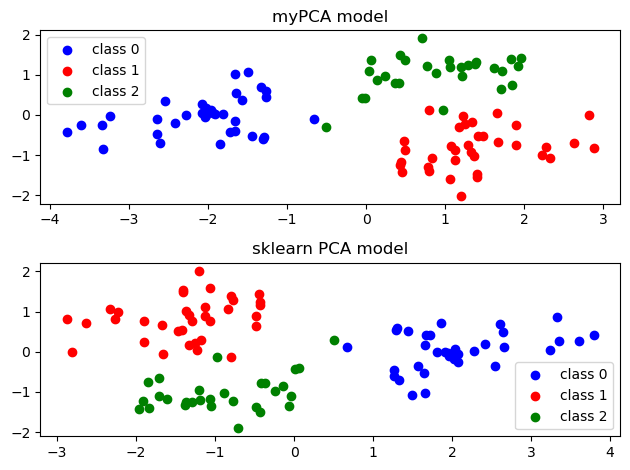

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)

ax[0].scatter(T[labels==0, 0], T[labels == 0,1], c = "b", label = "class 0")
ax[0].scatter(T[labels==1, 0], T[labels == 1,1], c = "r", label = "class 1")
ax[0].scatter(T[labels==2, 0], T[labels == 2,1], c = "g", label = "class 2")
ax[0].set_title("myPCA model")
ax[0].legend()

ax[1].scatter(T_sk[labels==0, 0], T_sk[labels == 0,1], c = "b", label = "class 0")
ax[1].scatter(T_sk[labels==1, 0], T_sk[labels == 1,1], c = "r", label = "class 1")
ax[1].scatter(T_sk[labels==2, 0], T_sk[labels == 2,1], c = "g", label = "class 2")
ax[1].set_title("sklearn PCA model")
ax[1].legend()

plt.tight_layout()
plt.show() 

### Differences 

PCs are the linear combinations of all data features, and the weight of each feature entry is called loading. In the above observation, we can see that the only difference between our PCA model and sklearn PCA model is the sign of principal components. The larger the magnitute of each entry in the vector indicates the contribution of a specific feature to the new coordinates. To even break it down more, each principal component represents the direction of the largest variance, which in terms, means that the loading of each feature reflects the degree of explanary in variance. Therefore, changing the sign doesn't change the intrisic natrue and the information in the dataset. 

For a feature $X_i$ with its PC loading $PC_i$. The new projection $T_i$ is computed by:

$T_i = X_i * PC_i$ --- (10)

Assume $X_i$ is real and $X_i > 0$, we can infer that a larger $X_i$ generates a larger $T_i$ value. Flipping the condition, by changing the direction of $PC$, assuming $new PC = -PC$, this gives:

$new T_i = X_i * new PC_i$ --- (11)

The equation (10) and (11) are essentially the same, except for the change of sign. By this, we can infer that the larger the $|PC_i|$ value, we can obtain a more negative $new T_i$ score. Although the result flipped, it is trivial to see that the representation of data is identical. 

Here if we reverse the direction of principal components:

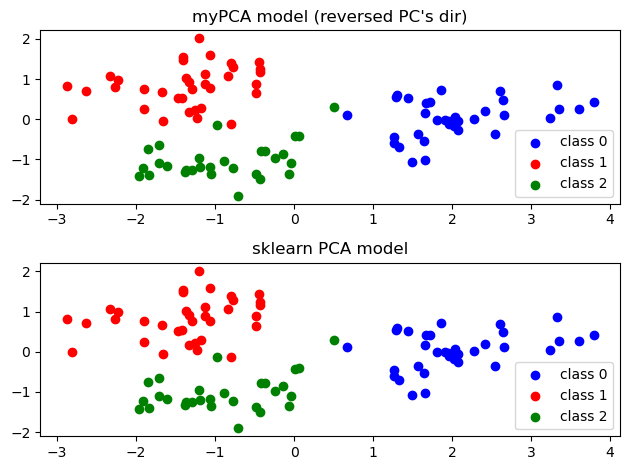

In [15]:
reverse_pc = -mypca.components_.T
T_reverse = X_std @ reverse_pc

# visualize
fig, ax = plt.subplots(2,1)

ax[0].scatter(T_reverse[labels==0, 0], T_reverse[labels == 0,1], c = "b", label = "class 0")
ax[0].scatter(T_reverse[labels==1, 0], T_reverse[labels == 1,1], c = "r", label = "class 1")
ax[0].scatter(T_reverse[labels==2, 0], T_reverse[labels == 2,1], c = "g", label = "class 2")
ax[0].set_title("myPCA model (reversed PC's dir)")
ax[0].legend()

ax[1].scatter(T_sk[labels==0, 0], T_sk[labels == 0,1], c = "b", label = "class 0")
ax[1].scatter(T_sk[labels==1, 0], T_sk[labels == 1,1], c = "r", label = "class 1")
ax[1].scatter(T_sk[labels==2, 0], T_sk[labels == 2,1], c = "g", label = "class 2")
ax[1].set_title("sklearn PCA model")
ax[1].legend()


plt.tight_layout()
plt.show() 


From the above visulaization, we can prove that flipping the direction of principal components doesn't change the result of the PCA dimensional reduction and it has been proven that the PCs calculated through SVD and eigendecomposition are functionally identical in the context of PCA.

# Results


## PCA application on Fault Diagnosis - Tennessee Eastman Process Dataset



In this section, I am applying PCA as a data preprocessing phase for this process fault diagnosis problem. The Tennessee Eastman Process (TEP) Simulation Dataset serves as the source of process simulation data, utilized here for the assessment and evaluation of anomaly detection methodologies. It contains 55 columns: 

Column 1 ("faultNumber") ranges from 1 to 20 represents the fault type in the TEP while 0 represents the normal operating conditions.

Column 2 ("simulationRun") represents a different random number generator state which will not be useful in the analysis. 

Column 3 ("sample") represents the sample number and which will is not informative in this analysis. 

Columns 4 to 55 are the process variables that are used in the analysis. 

- ### Fault types


- Read dataset 

In [16]:
import pyreadr
fault_free = pyreadr.read_r("./data/TEP_FaultFree_Training.RData") # normal conditions
faulty = pyreadr.read_r("./data/TEP_Faulty_Training.RData") # faulty conditions

In [17]:
# read in data to dataframes
import pandas as pd
df_train = faulty["faulty_training"]
df_ff = fault_free["fault_free_training"]

df = pd.concat([df_train,df_ff], axis=0) 
# display the first 10 rows
df.head(10)

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,1.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,1.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
5,1.0,1.0,6,0.29303,3691.7,4502.2,9.3780,27.111,41.999,2703.8,...,53.595,28.898,59.107,22.291,38.673,39.890,47.571,47.430,41.308,19.134
6,1.0,1.0,7,0.24301,3658.8,4541.6,9.3374,26.623,42.448,2704.0,...,53.548,23.558,62.125,22.244,40.429,35.816,45.514,47.508,41.338,17.625
7,1.0,1.0,8,0.24090,3653.3,4500.0,9.3495,27.075,42.412,2704.9,...,54.045,23.765,62.006,22.702,40.300,39.807,43.364,47.344,40.899,18.156
8,1.0,1.0,9,0.29416,3654.3,4454.7,9.3213,27.363,42.238,2703.2,...,54.083,28.697,61.623,22.064,38.976,38.066,45.381,47.483,40.876,18.146
9,1.0,1.0,10,0.29372,3675.9,4487.4,9.4107,26.809,42.144,2705.3,...,53.692,28.741,61.490,22.409,39.615,38.309,47.296,47.513,42.355,18.957


In [18]:
X = df.iloc[:,3:] # features space
labels = df.iloc[:,0] # fault label 

- Data Scaling

Standard scaling transforms the data by centering it and adjusting the scale of its distribution.

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

- Fitting PCA model

In [20]:
# fit pca 
mypca = myPCA()
T = mypca.fit_transform(X_std)
print("expalined variance ratio of components kept:", mypca.explained_variance_ratio_)

<class 'myPCA.myPCA'>
expalined variance ratio of components kept: [0.2469524366109493, 0.19176060180872817, 0.07569188036061764, 0.05536857201202127, 0.03862119876981261, 0.0369703791645913, 0.026875018015521307, 0.025184245539063867, 0.024070044435883085, 0.02226193523443732, 0.01948912019074879, 0.018789783268737866, 0.018228973530097812, 0.016960504996462452, 0.015910253577578547, 0.0154535257190482, 0.014401373973391862, 0.014277238757580656, 0.013484482377857689, 0.013239417541064698, 0.011688513103431872, 0.010751076034803757, 0.009481185738571409, 0.00908761186351124, 0.008445152107772375, 0.008165655361667142, 0.006447844929254166, 0.0059122331065411746, 0.00537178451976304, 0.0032958621962744534, 0.0023052198044813538, 0.0020573783310421125, 0.0018828142898387114, 0.0017922987544923615, 0.0013319125362308427, 0.0012572067640952529, 0.0012069633810401293, 0.0010691412819575368, 0.0009082807654600379, 0.0006865668794600289, 0.0006059351140103329, 0.000578855420974323, 0.0004995

- Visualizing Explained Variance Ratio 

explained variance ratio of every PC:  [0.2469524366109493, 0.19176060180872817, 0.07569188036061764, 0.05536857201202127, 0.03862119876981261, 0.0369703791645913, 0.026875018015521307, 0.025184245539063867, 0.024070044435883085, 0.02226193523443732, 0.01948912019074879, 0.018789783268737866, 0.018228973530097812, 0.016960504996462452, 0.015910253577578547, 0.0154535257190482, 0.014401373973391862, 0.014277238757580656, 0.013484482377857689, 0.013239417541064698, 0.011688513103431872, 0.010751076034803757, 0.009481185738571409, 0.00908761186351124, 0.008445152107772375, 0.008165655361667142, 0.006447844929254166, 0.0059122331065411746, 0.00537178451976304, 0.0032958621962744534, 0.0023052198044813538, 0.0020573783310421125, 0.0018828142898387114, 0.0017922987544923615, 0.0013319125362308427, 0.0012572067640952529, 0.0012069633810401293, 0.0010691412819575368, 0.0009082807654600379, 0.0006865668794600289, 0.0006059351140103329, 0.000578855420974323, 0.0004995370270884056, 0.000391820065

Text(0, 0.5, 'Explained variance ratio')

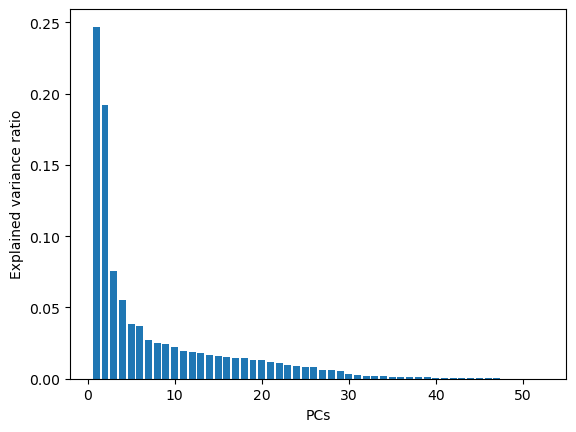

In [21]:
explained_var_ratio = mypca.explained_variance_ratio_
print("explained variance ratio of every PC: ", explained_var_ratio)
# Visualization 
plt.bar(range(1,len(explained_var_ratio)+1), explained_var_ratio)
plt.xlabel("PCs")
plt.ylabel("Explained variance ratio")

- Calculate the number of components needed to explain at least 80% of the variance in the dataset

In [22]:
exp_vars = 0
for pc, er in enumerate(explained_var_ratio, start=1):
    exp_vars += er
    if exp_vars >= 0.8:
        print("The minimum number of dimensions needed to explain at least 80%% of variance is %d" % pc)
        break

The minimum number of dimensions needed to explain at least 80% of variance is 13


- Visualizing the result


The visualization highlights that the central region of the graph represents normal process conditions. Notably, the projections exhibit a distribution along the upper-left to lower-right diagonal. This characteristic suggests that the majority of variation occurs within this specific manifold.

However, it's crucial to acknowledge that the information conveyed by the initial two dimensions may not be comprehensive enough to fully explain the dataset. As a result, while the visualization offers valuable insights, a more in-depth analysis in higher dimensions is imperative for a thorough understanding of the data.

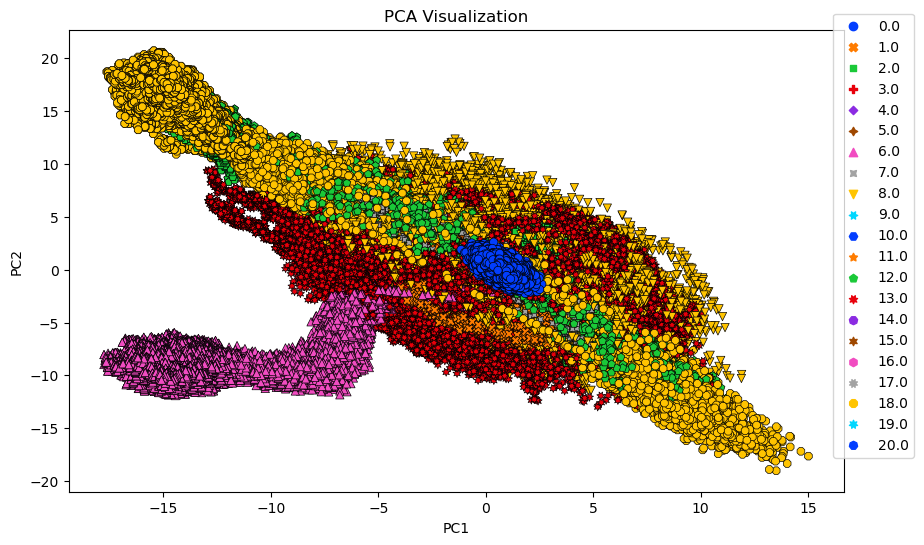

In [23]:
# Create a scatter plot of the embedded data, colored by the true labels
import seaborn as sns
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=T[:,0],y=T[:,1],hue= labels,style=labels,palette="bright",edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Conclusion 

In this project, I developed a PCA model that utilizes eigendecomposition for dimensionality reduction in high-dimensional data processing. The model takes Sklearn's version as a reference, following the same logic of implementation. It takes in n_component as the number of components to be preserved and includes methods such as fit, transform, and fit_transform. Upon validating our algorithm against the Sklearn version, there is no distinct difference in the performance of dimension reduction in terms of qualitative and quantitative measures. The only inconsistency is the opposite direction of principal components, which is evident only during the matrix operation for data projection. However, they are essentially identical, confirming the effectiveness of our PCA algorithm. In the example of the Tennessee Eastman Dataset, we illustrated the simplicity and broad applicability of PCA as a data preprocessing technique. When coupled with various data analysis techniques, PCA proves to be an effective method for reducing computational costs without sacrificing significant information. This underscores its versatility and utility in diverse analytical scenarios.

# Reference
- [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [skleanr.dataset.load_wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine)
- [Singular value decomposition and principal component analysis](https://link.springer.com/content/pdf/10.1007/0-306-47815-3_5.pdf)
- [Difference between SVD and eigendecomposition](https://math.stackexchange.com/questions/320220/intuitively-what-is-the-difference-between-eigendecomposition-and-singular-valu)

- [A plant-wide industrial process control problem](https://www.sciencedirect.com/science/article/abs/pii/009813549380018I)

- [Tennessee Eastman Process Simulation Dataset](https://www.kaggle.com/datasets/averkij/tennessee-eastman-process-simulation-dataset/code)

